In [50]:
!pip install pandas numpy scikit-learn matplotlib seaborn tensorflow transformers

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import pandas as pd
import json
import os
import tarfile

In [53]:
reviewfile = '/content/drive/MyDrive/yelp_academic_dataset_review.json'

In [54]:
data = []
with open(reviewfile, 'r') as f:
    for i, line in enumerate(f):
        record = json.loads(line)
        data.append({'text': record['text'], 'stars': record['stars']})
        if i >= 100000:
            break

In [55]:
print(len(data))

100001


In [56]:
df_reviews = pd.DataFrame(data)
dforiginalcopy = df_reviews.copy()

print(df_reviews.head(21))

                                                 text  stars
0   If you decide to eat here, just be aware it is...    3.0
1   I've taken a lot of spin classes over the year...    5.0
2   Family diner. Had the buffet. Eclectic assortm...    3.0
3   Wow!  Yummy, different,  delicious.   Our favo...    5.0
4   Cute interior and owner (?) gave us tour of up...    4.0
5   I am a long term frequent customer of this est...    1.0
6   Loved this tour! I grabbed a groupon and the p...    5.0
7   Amazingly amazing wings and homemade bleu chee...    5.0
8   This easter instead of going to Lopez Lake we ...    3.0
9   Had a party of 6 here for hibachi. Our waitres...    3.0
10  My experience with Shalimar was nothing but wo...    5.0
11  Locals recommended Milktooth, and it's an amaz...    4.0
12  Love going here for happy hour or dinner!  Gre...    4.0
13  Good food--loved the gnocchi with marinara\nth...    4.0
14  The bun makes the Sonoran Dog. It's like a snu...    4.0
15  Great place for brea

Now, we have 100,000 rows. It is important to clean this dataset like making sure the granularity of the data is enough, handling missing values.

In [57]:
print(df_reviews.isnull().sum())

text     0
stars    0
dtype: int64


In [58]:
df_reviews.loc[df_reviews['stars'] == 0, 'sentiment'] = 0
df_reviews = df_reviews[df_reviews['stars'] != 3]

In [59]:
df_reviews['sentiment'] = df_reviews['stars'].apply(lambda x: 1 if x > 3 else 0)

In [60]:
df_reviews = df_reviews[['text', 'sentiment']]

In [61]:
print(df_reviews.head())
print(df_reviews['sentiment'].value_counts())

                                                text  sentiment
1  I've taken a lot of spin classes over the year...          1
3  Wow!  Yummy, different,  delicious.   Our favo...          1
4  Cute interior and owner (?) gave us tour of up...          1
5  I am a long term frequent customer of this est...          0
6  Loved this tour! I grabbed a groupon and the p...          1
sentiment
1    69729
0    18909
Name: count, dtype: int64


## Feature Engineering


In [62]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

df_reviews['review_length'] = df_reviews['text'].apply(len)
positive_reviews = ' '.join(df_reviews[df_reviews['sentiment'] == 1]['text'])
negative_reviews = ' '.join(df_reviews[df_reviews['sentiment'] == 0]['text'])

In [63]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(background_color='black').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

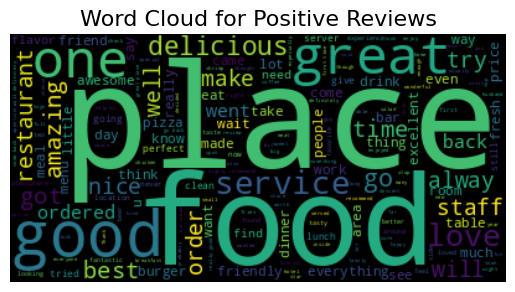

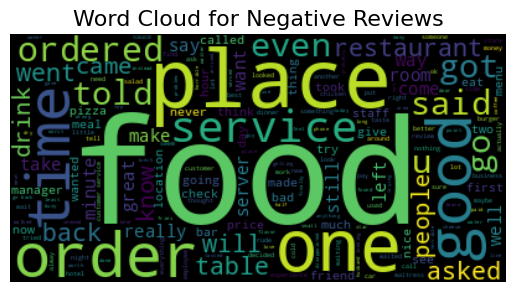

In [64]:
generate_wordcloud(positive_reviews, "Word Cloud for Positive Reviews")
generate_wordcloud(negative_reviews, "Word Cloud for Negative Reviews")

Does lengh of a review have anything to do with how positive or negative it is? We can review word length as well as sentiment

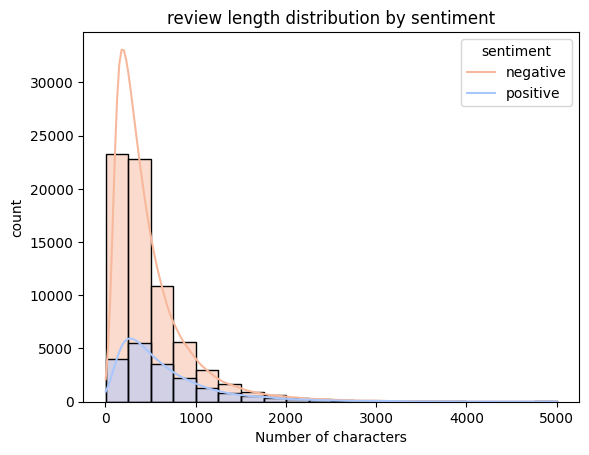

In [65]:
sns.histplot(df_reviews, x='review_length', hue='sentiment', bins=20, kde=True, palette='coolwarm')
plt.title("review length distribution by sentiment")
plt.xlabel("Number of characters")
plt.ylabel("count")
plt.legend(labels=['negative', 'positive'], title='sentiment')
plt.show()

In [66]:
print("Positive Reviews")
print(df_reviews[df_reviews['sentiment'] == 1]['text'].sample(3).values)
print("\nNegative Reviews")
print(df_reviews[df_reviews['sentiment'] == 0]['text'].sample(3).values)

Positive Reviews
['One of the first places we stopped at on our trip to Philly. Made it in time for their awesome happy hour. The drinks were delicious and had the right amount of mixes. The sample board is a must try!'
 "Best by far Restaurant & Bar \nin ruskin / sun city center, fl\n===   ===   ===   ===  TAP HERE       \n** Breakfast has great choices, \nmade fresh to order. \n** Lunch specials & daily menu \nselections will bring a truly \nsatisified smile to your face.\n*** FRIDAY offers,  \n11:00 a.m. - 8:00 p.m.   $9.99 \nAll-U-Can-Eat Fish Fry that \nincludes fresh cooked fish, \ncole slaw, with choice of \nwhite clam chowder -or- \nred crab soup -or- potato soup.\n*** SUNDAY Special of fresh \n    mimosas are available to \ncompliment your meal.\n**  don't forget the bar with \ndrink options that include \nwine- by the glass or Half Carafe.\n  == YOU WILL LOVE IT == \ntop notch, friendly staff,\nfast professional kitchen,\ngive the best of service..!!!  \n  we highly recommend

### **Since we are applying sentiment analysis for our project and we want to identify on the basis of text and stars whether the reviews are positive or not. 3 star reviews which have neutral language can be confusing, and so for the sake of this project we will be excluding 3 star reviews.**

---



If the star rating was 0 to 2 then the sentiment is 0 and if the star rating was 4 or 5, the sentiment is labelled as 1.

In [67]:
#splitting the dataset into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_reviews['text'], df_reviews['sentiment'], test_size=0.2, random_state=42)

In [68]:
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 70910
Testing set size: 17728


In [69]:
len(X_train) + len(X_test)

88638

In [70]:
print("original dataset size:", len(data))
print("filtered dataset size:", len(df_reviews))
print("3 star rows", sum(dforiginalcopy['stars'] == 3))

original dataset size: 100001
filtered dataset size: 88638
3 star rows 11363


# Preprocessing data

In [71]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [72]:
print(X_train.head())

68476    great hotel the layout is really cool with a c...
98958    tldr friendly service atmosphere and decent fo...
32621    wonderful service expansive menu great atmosph...
18540    why are all your listings advertised as mens s...
99416    both times i have been here i have experienced...
Name: text, dtype: object


# Vectorization

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_tokenized, maxlen=200, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, maxlen=200, padding='post')

# **DECISION TREE MODEL**

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
dt_classifier.fit(X_tfidf, y_train)
y_pred = dt_classifier.predict(X_test_tfidf)

print("Decision Tree classification-")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Decision Tree classification-
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3783
           1       0.90      0.89      0.89     13945

    accuracy                           0.83     17728
   macro avg       0.75      0.76      0.75     17728
weighted avg       0.83      0.83      0.83     17728


Confusion Matrix:
[[ 2359  1424]
 [ 1565 12380]]

Accuracy Score:
0.8313966606498195


In [76]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(dt_classifier, out_file=None,
                                feature_names=tfidf_vectorizer.get_feature_names_out(),
                                class_names=['Negative', 'Positive'],
                                filled=True)


graph = graphviz.Source(dot_data, format="png")
graph.render("decision_tree")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.847876 to fit


'decision_tree.png'

# **RANDOM FOREST MODEL**

In [77]:
#random forest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

tfidf_vectorizer = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train_tfidf, y_train)
y_pred = rf_classifier.predict(X_test_tfidf)

print("Random-Forest classification-")
print(classification_report(y_test, y_pred))
print("\nRandom-Forest confusion matrix-")
print(confusion_matrix(y_test, y_pred))
print("\nRandom-Forest accuracy-")
print(accuracy_score(y_test, y_pred))

importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = tfidf_vectorizer.get_feature_names_out()
for idx in indices[:20]:
    print(f"{feature_names[idx]}: {importances[idx]}")


Random-Forest classification-
              precision    recall  f1-score   support

           0       0.88      0.55      0.68      3783
           1       0.89      0.98      0.93     13945

    accuracy                           0.89     17728
   macro avg       0.88      0.76      0.80     17728
weighted avg       0.89      0.89      0.88     17728


Random-Forest confusion matrix-
[[ 2078  1705]
 [  284 13661]]

Random-Forest accuracy-
0.8878046028880866
not: 0.03924220110767387
great: 0.034468113035702005
no: 0.022144891065327292
delicious: 0.019529818069005
told: 0.016834121390326043
and: 0.013484450142506927
was: 0.01321220255415811
asked: 0.012959541005285924
amazing: 0.012020089105867071
bad: 0.011979458021664852
minutes: 0.01090483067131505
money: 0.01018593523936987
said: 0.010046249172877475
best: 0.009970966408299269
to: 0.009703191245135778
friendly: 0.009576465380291815
never: 0.009383181789005745
definitely: 0.00850364022337495
is: 0.008251936080331604
love: 0.0075675

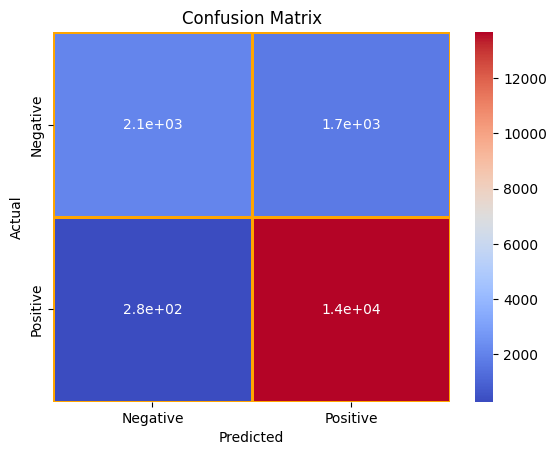

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,annot=True,cmap='coolwarm',xticklabels=['Negative', 'Positive'],yticklabels=['Negative', 'Positive'],cbar=True,linewidths=2,linecolor='ORANGE')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

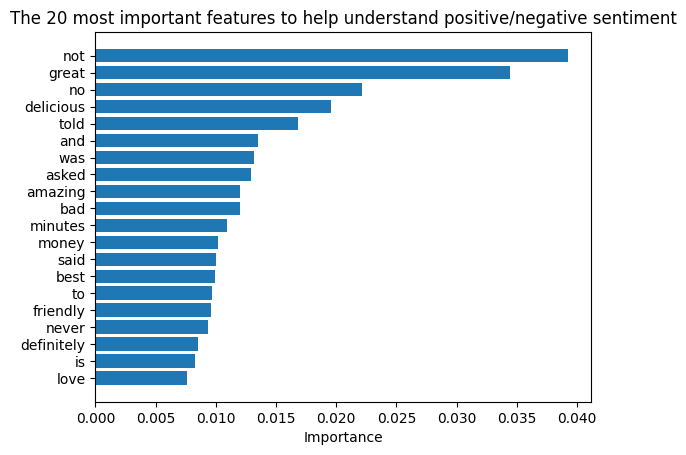

In [79]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = tfidf_vectorizer.get_feature_names_out()

plt.barh(range(20), importances[indices[:20]][::-1], align='center')
plt.yticks(range(20), [feature_names[i] for i in indices[:20]][::-1])
plt.xlabel('Importance')
plt.title('The 20 most important features to help understand positive/negative sentiment')
plt.show()

# **Neural Network Model**

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

Hyper paramter tuning

In [81]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [82]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxwords = 20000
maximumlength = 200
tokenizer = Tokenizer(num_words=maxwords, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=maximumlength, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=maximumlength, padding='post')


In [83]:
X_train_small = X_train_padded[:5000]
y_train_small = y_train[:5000]

In [84]:
def build_model(hp):
    model = Sequential([
        Embedding(input_dim=20000,output_dim=hp.Int('embedding_dim', min_value=32, max_value=64, step=16),input_length=200),LSTM(hp.Int('lstm_units', min_value=32, max_value=96, step=32)),Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)),
        Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'), Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.3, step=0.1)),Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.01])),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [85]:
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=3, factor=2, directory='my_dir', project_name='sentiment_analysis')


Reloading Tuner from my_dir/sentiment_analysis/tuner0.json


In [86]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [87]:
tuner.search(X_train_small, y_train_small, epochs=2, validation_split=0.05, callbacks=[early_stopping])

In [88]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [89]:
print(f"""
The optimal hyperparameters are:
Embedding- {best_hps.get('embedding_dim')}
LSTM needed- {best_hps.get('lstm_units')}
dropout rate- {best_hps.get('dropout_rate')}
dense- {best_hps.get('dense_units')}
learning rate- {best_hps.get('learning_rate')}""")


The optimal hyperparameters are:
Embedding- 32
LSTM needed- 64
dropout rate- 0.2
dense- 64
learning rate- 0.01


Since we have the optimal parameters, we can build the Neural network model

In [90]:
final_model = Sequential([Embedding(input_dim=20000, output_dim=32, input_length=200), LSTM(64, return_sequences=False), Dropout(0.2), Dense(64, activation='relu'), Dropout(0.2), Dense(1, activation='sigmoid')])
final_model.compile(optimizer=Adam(learning_rate=0.01),loss='binary_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [91]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
history = final_model.fit(X_train_padded, y_train,epochs=5,batch_size=512,validation_data=(X_test_padded, y_test),callbacks=[early_stopping])

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.7854 - loss: 0.5156 - val_accuracy: 0.7871 - val_loss: 0.4139
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8972 - loss: 0.2398 - val_accuracy: 0.9471 - val_loss: 0.1315
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.9702 - loss: 0.0863 - val_accuracy: 0.9592 - val_loss: 0.1161
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9848 - loss: 0.0472 - val_accuracy: 0.9552 - val_loss: 0.1417
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9903 - loss: 0.0307 - val_accuracy: 0.9513 - val_loss: 0.1656


### We've gotten good accuracy. Now let's evaluate on test data

In [92]:
test_loss, test_accuracy = final_model.evaluate(X_test_padded, y_test, batch_size=512)
print(f"Test Loss- {test_loss}")
print(f"Test Accuracy- {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.9593 - loss: 0.1138
Test Loss- 0.11608459800481796
Test Accuracy- 0.9592170715332031


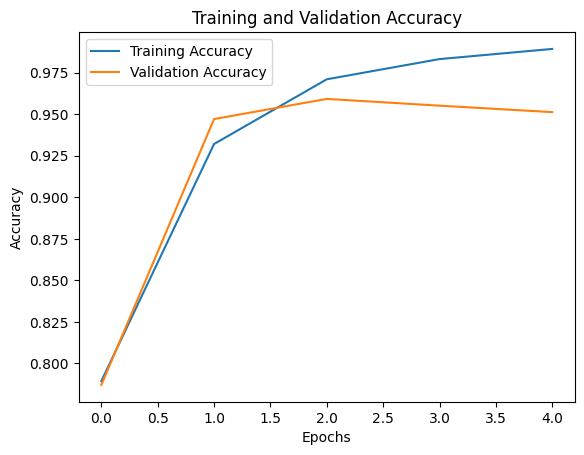

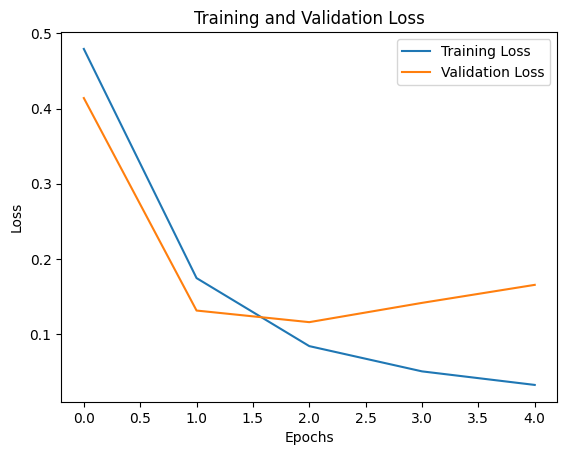

In [93]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#Prediction

In [94]:
y_pred_probs = final_model.predict(X_test_padded, batch_size=512)
y_pred = (y_pred_probs > 0.5).astype(int)

35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 520ms/step


In [95]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      3783
           1       0.97      0.98      0.97     13945

    accuracy                           0.96     17728
   macro avg       0.94      0.93      0.94     17728
weighted avg       0.96      0.96      0.96     17728



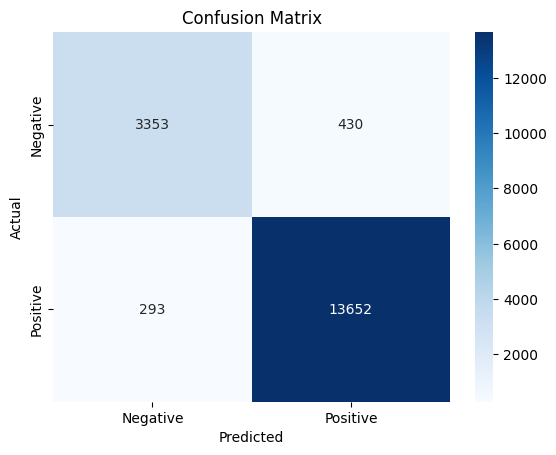

In [96]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [97]:
def predict_sample_reviews(reviews, tokenizer, model, max_len=1000):
    for i, review in enumerate(reviews, 1):
        sequence = tokenizer.texts_to_sequences([review])
        padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')
        prediction = final_model.predict(padded_sequence, verbose=0)[0][0]
        sentiment = "Positive" if prediction > 0.5 else "Negative"

        print(f"Sample {i}:")
        print(f"Review: {review}")
        print(f"Predicted Sentiment: {sentiment} (Probability: {prediction:.2f})\n")

sample_reviews = [
    "I guess the food was edible, but that's the best thing I can say about it.",
    "Oh wow, what an experience.!..f waiting for an hour just to get cold pizza!",
    "The ambiance was nice, but the food?????? Let's just say it’s an acquired taste",
    "If you like to be in the company of weirdoes and enjoy rude waiters and overpriced coffee, this is the place for you!",
    "The dessert looked great on social mdia, but tasted like thermacol",
    "The steak was overcooked and not something to bve consumed, the salad was soggy, but hey, the water was free",
    "Surprisingly, the service was good this time, though the food still needs improvement.",
    "Wow, what a waste of time. Can't believe I paid for this disappointment.",
    "The waiter was super friendly, but the food tasted like it came out of a microwave.",
    "Honestly, the vibe of the place is amazing but the menu items don't justify the price tag.",
    "bELLISMO"
]

predict_sample_reviews(sample_reviews, tokenizer, final_model)


Sample 1:
Review: I guess the food was edible, but that's the best thing I can say about it.
Predicted Sentiment: Positive (Probability: 0.62)

Sample 2:
Review: Oh wow, what an experience.!..f waiting for an hour just to get cold pizza!
Predicted Sentiment: Negative (Probability: 0.20)

Sample 3:
Review: The ambiance was nice, but the food?????? Let's just say it’s an acquired taste
Predicted Sentiment: Positive (Probability: 0.58)

Sample 4:
Review: If you like to be in the company of weirdoes and enjoy rude waiters and overpriced coffee, this is the place for you!
Predicted Sentiment: Negative (Probability: 0.07)

Sample 5:
Review: The dessert looked great on social mdia, but tasted like thermacol
Predicted Sentiment: Positive (Probability: 0.75)

Sample 6:
Review: The steak was overcooked and not something to bve consumed, the salad was soggy, but hey, the water was free
Predicted Sentiment: Negative (Probability: 0.07)

Sample 7:
Review: Surprisingly, the service was good this tim